#Some investigations into copulas

We will proceed as follows:

- Analyse the one dimensional case where normal does not work
- Analyse the one dimensional case where t distribution is required.
- Analyse the multidimensional case where gausian distributoin does not work
- Analyse the case case where multidimensional T distributoin works.

In [6]:
from __future__ import division, print_function
from pandas.io.data import DataReader
from datetime import datetime
from scipy.optimize import fmin
from decimal import Decimal
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [7]:
inf = Decimal('Infinity')
neginf = Decimal('-Infinity')

In [8]:
def gausspdf(x, args):   
    if type(args) == np.float64:
        mu = args
        sigma = 1
    elif len(args) == 2:
        mu = args[0]
        sigma= args[1]
    else:
        "Problem with Argument Type"
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

def loglikelihood(pdf, x, parameters):
    """"minus log likelihood of a model pdf, given the data sample x"""
    return -np.sum(np.log(pdf(x, parameters))) #calls the above function

In [19]:
def fitpdf(x,pdf,parameterlist):
    """Maximum likelihood fit for pdf."""

    def f(parameterlist):
        return loglikelihood(pdf, x, parameterlist)
    
    minparam = fmin(f, parameterlist, xtol= 1e-8, disp=0)
    llh = -f(minparam)
    
    return llh, minparam

In [17]:
from scipy.optimize import fminbound

def fitpdf2(x,pdf,parameterlist,lb,ub):
    """Sometimes the optimisation procedure leads to Urealistic  parameter estimates, 
       therefore we uses a bounded optimisation procedure.
       
       However, in scipy, the bounded optimisation can only handle one variable so we 
       fix one of the parameters when we call it"""
    
    def f(parameterlist):
        return loglikelihood(pdf, x, parameterlist)
    
    minparam= fminbound(f, lb, ub, xtol= 1e-8, disp=0)
    llh = -f(minparam)
    return llh, minparam

In [11]:
# to test the above infrastracture
def test_fit(pdf, fitmethod, parameterlist, lowerbound=neginf, upperbound=inf):
    mu = parameterlist[0]
    if len(parameterlist) == 2:
        sigma = parameterlist[1]
    else:
        sigma =1
        
    x = sigma * np.random.randn(1000) + mu 
    
    if fitmethod ==fitpdf:   
        llh, param = fitmethod(x, pdf, parameterlist)
    else:
        llh, param = fitmethod(x, pdf, parameterlist, lowerbound, upperbound)
    
    if fitmethod == fitpdf:
        print("Estimated parameters {0},{1}".format(param[0],param[1]))
    else:
        print("Estimated parameters {}".format(param))
        
    return llh, param

#test_fit(gausspdf, fitpdf, [10,3]);
test_fit(gausspdf, fitpdf2,[10],0,15)

Estimated parameters 10.001765672


(-1393.9061852059517, 10.001765672042305)

Consider now the log return of Google Stock.

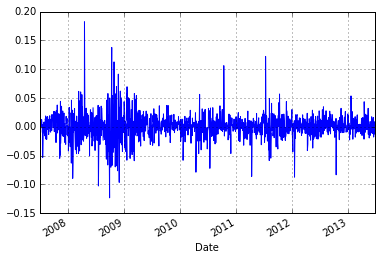

In [20]:
S=DataReader("GOOGL", "yahoo", datetime(2007,7,1),datetime(2013, 6, 30))['Adj Close']
logReturn = np.log(S/S.shift(1))
logReturn.dropna(inplace = True)
logReturn.plot()
plt.show()

In [37]:
def graphical_comparison_pdf(x, modelpdf, scale = True, xmin= None, xmax=None, 
                             axes_object=None, nbins=None):
    _x =x[np.logical_not(np.isnan(x))]
    if xmax is None:
        xmax = np.max(_x)
    if xmin is None:
        xmin = np.min(_x)
    
    nplot = 1000
    xplot = np.linspace(xmin, xmax, nplot)
    yplot = modelpdf(xplot)
    
    if nbins is None:
        nbins =np.min([np.sqrt(x.size), 40])
        
    width_histogram          = np.max(_x)-np.min(_x)
    average_height_histogram = x.size/nbins
    area_histogram           = width_histogram*average_height_histogram
    
    pdfscalefactor= area_histogram if not scale else 1
    #if scale = false we scale modelpdf(x) by the area of the histogram
    #if scale = true the historgram is scalled such ath its area is 1
    
    if axes_object is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = axes_object
    
    _, _, p = ax.hist(_x, bins=nbins, normed=scale)
    l, = ax.plot(xplot, yplot*pdfscalefactor, 'r', linewidth=3)
    
    ax.set_xlabel('x')
    ax.set_ylabel('pdf(x)')
    ax.set_xlim(xmin, xmax)
    
    if scale:
        plt.legend([l,p[0]], ['pdf(x)', 'scaled histogram'], loc = 'best')
    else:
        plt.legend([l,p[0]], ['scalled pdf(x)', 'histogram'], loc = 'best')
    return ax       

The pdf we use the normal distribution

In [25]:
def gausspdf1(x, args):
    mu, sigma = args
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

next, we obtain, the MLE and compare it to the sample estimates of the mean and standard deviation. 

Estimated Parameters: 0.000335811350516 0.0209772909183
Sample estimates: 0.000335812691068 0.0209842419645


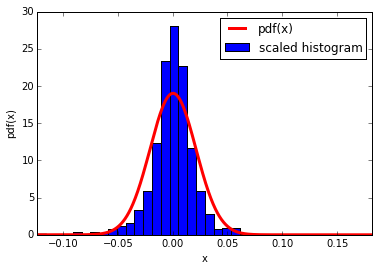

In [38]:
def fit_returns(x):
    LL, (mu, sigma) = fitpdf(x, gausspdf, [0,1])
    print ("Estimated Parameters:", mu, sigma)
    print ("Sample estimates:", logReturn.mean(), logReturn.std())
    
    def modelpdf(x):
        return gausspdf1(x, (mu, sigma))
    graphical_comparison_pdf(x, modelpdf)
    

fit_returns(logReturn)

### Student t-distribution

from the above fit we notice that the normal distribution does not produce  a high quality fits to the stock data. In particular it underestimates teh  tail events. Here we look at the student t distribuiton as an alternative tool.

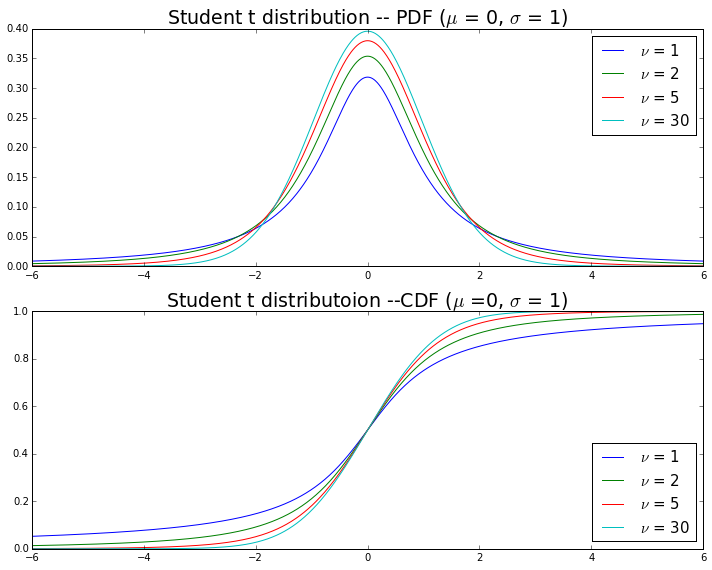

In [45]:
from scipy.stats import t as  tdist

# dfine the cdf, inv, pdf functions

def Tcdf(x, mu, sigma, df):
    return tdist.cdf((x- mu)/sigma, df)

def Tinv(p, mu, sigma,df):
    return mu + sigma*tdist.ppf(p,df)

def Tpdf(x, mu, sigma, df):
    return tdist.pdf((x-mu)/sigma, df)/sigma


#Tpdf(np.linspace(-6, 6, 1000), 0, 1, 1)


def studentT():
    mu = 0
    sigma = 1 
    df = [1,2,5,30]
    alpha = 6

    xmin = mu - alpha*sigma
    xmax = mu + alpha*sigma
    nplot = 1000
    xplot = np.linspace(xmin, xmax, nplot)
    fig = plt.figure(figsize = (10,8))
    ax_pdf = fig.add_subplot(211)
    ax_cdf = fig.add_subplot(212)
    for n in df:
        ax_pdf.plot(xplot,Tpdf(xplot, mu, sigma, n), label = r'$\nu$ = {}'.format(n))
        ax_cdf.plot(xplot,Tcdf(xplot, mu, sigma, n), label = r'$\nu$ = {}'.format(n))
    ax_pdf.set_title('Student t distribution -- PDF ($\mu$ = {}, $\sigma$ = {})'
                     .format(mu, sigma), fontsize = 19)
    ax_pdf.legend(fontsize = 15)
    ax_cdf.set_title('Student t distributoion --CDF ($\mu$ ={}, $\sigma$ = {})'
                     .format(mu,sigma), fontsize=19)
    ax_cdf.legend(fontsize = 15, loc = 'lower right')
    fig.tight_layout()
    
studentT()


Next we write a function which fits the distribution to a dateset, using moment estimates 
for mean and standard deviation as inputs

Estimated parameters (MLE) vs True Parameters
Mean: 2.97762 3
Std:  1.95797 2
DF:   2.36414 2.5


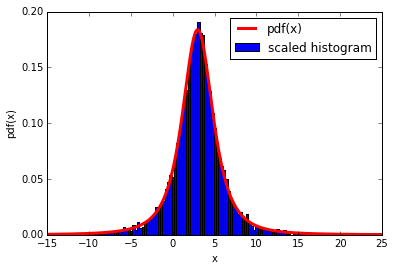

In [49]:
def fit_studentT(x, df0):
    """
    fit_studentT(x:Array[1], df:float) -> ([mu:float, sigma:float, df:int}, pdf, cdf, inv)
    """
    mu0 = np.mean(x) #match first moment
    sigma0 = np.sqrt(np.var(x) * (df0 - 2)/df0) # match second moment
    
    def pdf_handle(x, args):
        _mu, _sigma, _df = args
        return Tpdf(x, _mu, _sigma, _df)
    
    LL, args_out =fitpdf(x,pdf_handle, [mu0, sigma0, df0])
    mu, sigma, df = args_out
    
    pdf = lambda x: Tpdf(x, mu, sigma, df)
    cdf = lambda x: Tcdf(x, mu, sigma, df)
    inv = lambda p: Tinv(p, mu, sigma, df)
    
    return [mu, sigma, df], pdf, cdf, inv   

def fit_example():
    mu = 3
    sigma = 2
    df = 2.5
    nosims = 10000
    
    x = mu + sigma*tdist.rvs(df, size=nosims)
    
    df0 = 5
    
    args_out, pdf, cdf, inv = fit_studentT(x, df0)
    mu_mle, sigma_mle, df_mle = args_out
    
    graphical_comparison_pdf(x, pdf, xmin=-15, xmax=25, nbins=1000)
    
    print("Estimated parameters (MLE) vs True Parameters")
    print("Mean:", np.round(mu_mle, 5), mu)
    print("Std: ", np.round(sigma_mle, 5), sigma)
    print("DF:  ", np.round(df_mle, 5), df)

fit_example()
    
    

###Multivariate Gaussians

We want a random number generator which draws samples from a multivariate Gaussian
ditribution. Such a distribution is  characterised by 

* D - dimensional vector of means
* DxD - dimensional covariance matrix

The method employed is to draw samples from a standardised normal distributio, and then transform this into the appropriate multivariate Gaussian distribution using the cheolesky  decomposition of the covariance matrix. 

In [61]:
from scipy.linalg import cholesky

def mtvrt_gaussian_rand(mu,sigma, nosims):
    mu = np.asarray(mu)
    sigm = np.asarray(sigma)
    
    D = mu.size
    L = cholesky(sigma).T
    x = np.random.randn(D, nosims) 
    z = mu[:, np.newaxis] + np.dot(L,x)
    return z.T
    

sigma = [[1, 0.8, 0.1],
         [.8,  1, 0.2],
         [0.1, 0.2, 1]]

mean = [1,2,3]

print(mtvrt_gaussian_rand(mean, sigma, 5))

[[ 1.56734843  3.06957864  3.19323382]
 [-0.05846623  1.01882465  4.21055559]
 [ 0.57258201  2.17466747  3.47414583]
 [ 2.37816907  3.25438334  1.72490856]
 [ 0.50382076  2.81861573  2.9766249 ]]


Now we plot the case of 2D gaussian distribution.

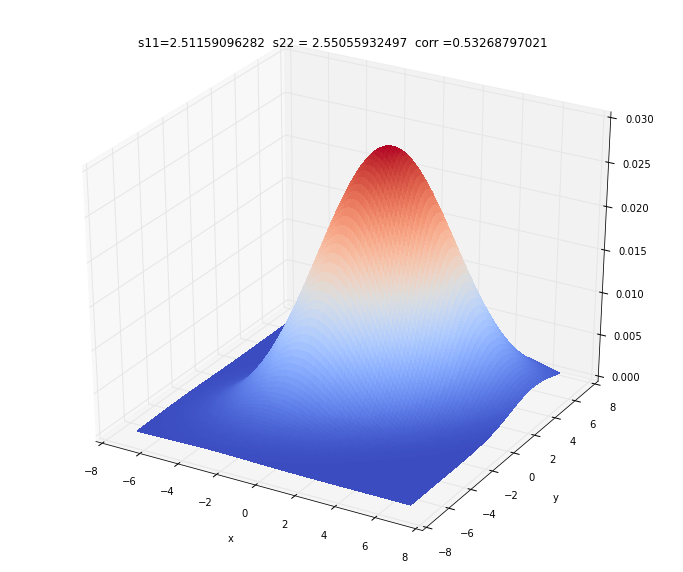

In [82]:
from numpy import mgrid
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from matplotlib import cm

Numpoints=1000
m1=1    #Mean of first dimension
m2=1    #Mean of first dimension
mean=np.array(([m1,m2]))
s11=2.5 #standard deviation of x1
s22=2.5 #standard deviation of x2 
rho=0.5 #correlation coefficient between s11 and s22
#Determine covariance matrix from standard deviations
var11=s11**2
var22=s22**2
var12=rho*s11*s22
var21=var12
cov=np.array(([var11,var12],[var21,var22]))


pointset=np.random.multivariate_normal(mean,cov,Numpoints)
est_cov=np.cov(pointset,rowvar=0)
est_mean=np.mean(pointset,axis=0)


[m1,m2]=est_mean
s11=np.sqrt(est_cov[0,0])
s22=np.sqrt(est_cov[1,1])
corr=est_cov[0,1]/(s11*s22)


x,y = mgrid[-7:7:100j, -7:7:100j]


s11=np.sqrt(est_cov[0,0])
s22=np.sqrt(est_cov[1,1])
corr=est_cov[0,1]/(s11*s22)


a=1.0/(2*np.pi*s11*s22*np.sqrt(1-corr**2))*np.exp(-1.0/(2*(1-corr**2))
    *(((x-m1)**2)/(s11**2)+((y-m2)**2)/(s22**2)-2*corr*(x-m1)*(y-m2)/(s11*s22)))  

         
         
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x,y,a,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0.0, antialiased=False)
#plt.text(0.5,0.5,0.2,'$\sigma_{11}$='+str(s11)+'\n$\sigma_{22}$='+str(s22)+
         #'\n$corr$='+str(corr),fontsize=14,backgroundcolor='white')
plt.title('s11='+str(s11)+'  s22 = '+str(s22)+'  corr ='+str(corr))
plt.xlabel('x')
plt.ylabel('y')
plt.show()